In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from genw_sparse import *
from run_rate import *
from train_QIF import *

In [3]:
# parameters
N = 100
tau_x = 10 # ms, used in paper
gain = 1.2 # scalar, used in paper
T = 1000 # ms
dt = 0.1 # ms

rate_params = N, tau_x, gain, T, dt

stim_on = 0 # ms
stim_off = 1000 # ms

nloop = 10
train_every = 2 # ms

tau = 1 # ms, neuron phase decay constant
tau_s = 20 # ms, spike train decay constant 
lam = 1 # learning rate constant

neuron_params = N, tau, tau_s, lam
time_params = T, stim_on, stim_off, dt
train_params = nloop, train_every

timesteps = int(T/dt)

In [4]:
# parameters
 
stim_on = 0 # ms
stim_off = 50 # ms

nloop = 10
train_every = 2 # ms

timesteps = int(T/dt) # unitless, total number of timesteps

tau = 1 # ms, neuron phase decay constant
tau_s = 20 # ms, spike train decay constant 
lam = 1 # learning rate constant

neuron_params = N, tau, tau_s, lam
time_params = T, stim_on, stim_off, dt
train_params = nloop, train_every

run_time = T # ms

In [5]:
def gen_rand_stim(N, timesteps):
    stim = np.zeros((N, timesteps))
    for row in range(N):
        rstim = 2 * sp.stats.uniform.rvs(0, 1) - 1 # random stim weight from -1, 1
        stim[row][int(stim_on/dt):int(stim_off/dt)] = rstim
    return stim

In [6]:
# input stim set to 0
fin = gen_rand_stim(N, timesteps)

In [7]:
# fout, driving stim set to our data
raw_waveforms = np.transpose(np.load("raw_form.npy"))
fout = raw_waveforms[0][0:timesteps]
inp_w = sp.stats.uniform.rvs(size = N)
fdrive = np.outer(inp_w, fout)

In [8]:
J = genw_sparse(N, 0, 1/np.sqrt(N), 1)

In [9]:
x = run_rate(rate_params, J, fin, fdrive)

Text(0.5, 1.0, 'Sample driven neuronal behavior')

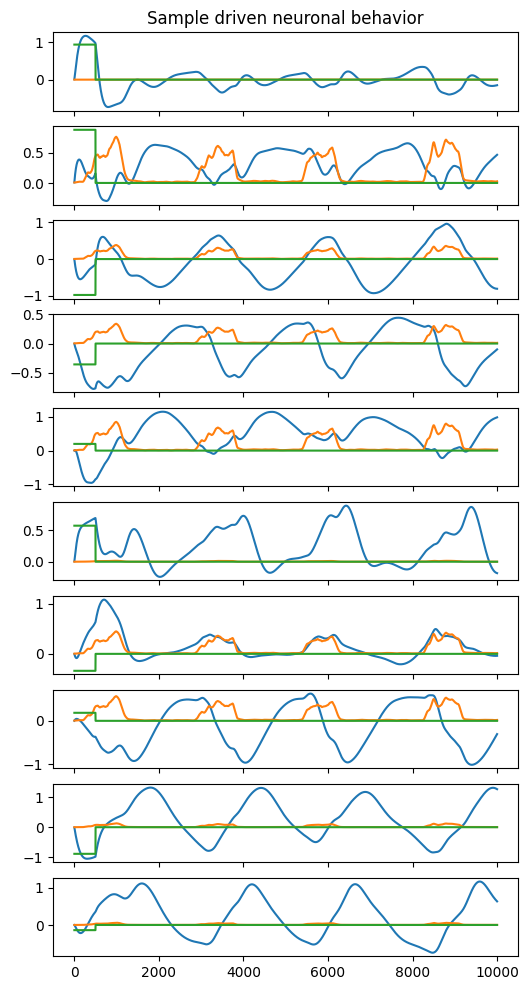

In [10]:
n_plot = 10

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(x[i])
    axs[i].plot(fdrive[i])
    axs[i].plot(fin[i])

axs[0].set_title("Sample driven neuronal behavior")

In [11]:
# generate auxillary targets
# internal activity plus external activity

aux_targs = x + fdrive

In [12]:
W = genw_sparse(N, 0, 1/np.sqrt(N), 0.3)
W_trained = np.copy(W)

In [13]:
W_trained, spks_t, sdrive_t, thetas_t, spk_rast_t = train_QIF(neuron_params, time_params, train_params, W_trained, fin, aux_targs)

0
1
2
3
4
5
6
7
8
9


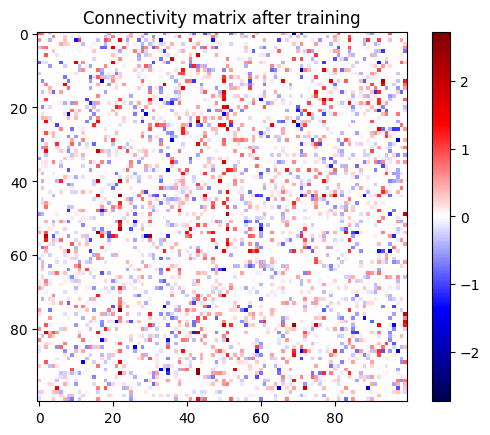

In [14]:
plt.imshow(W_trained, cmap=plt.get_cmap('seismic'), vmin = -(max(-1*np.min(W_trained), np.max(W_trained))), vmax = (max(-1*np.min(W_trained), np.max(W_trained))))
plt.title("Connectivity matrix after training")
plt.colorbar()

C:\Users\sq373\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.0, 'Clustered connectivity matrix after training')

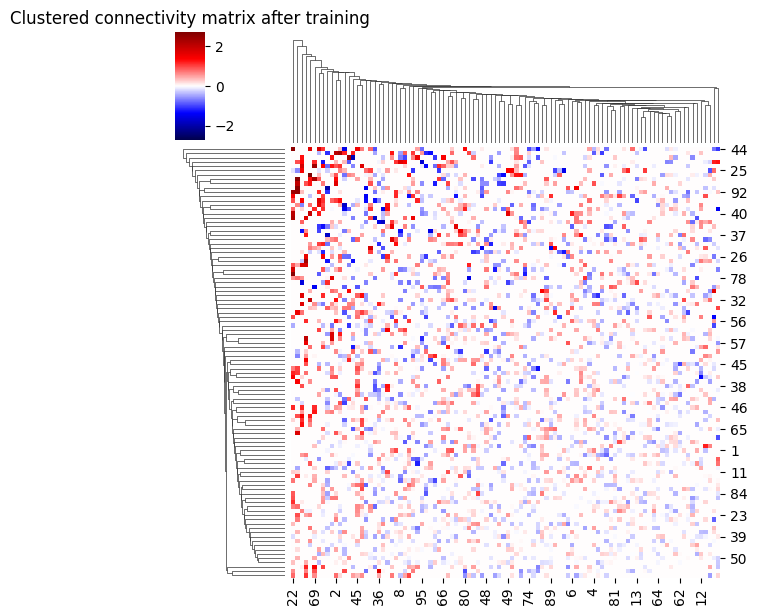

In [15]:
sns.clustermap(W_trained, cmap=plt.get_cmap('seismic'), vmin = -(max(-1*np.min(W_trained), np.max(W_trained))), vmax = (max(-1*np.min(W_trained), np.max(W_trained))), figsize = (6, 6))
plt.title("Clustered connectivity matrix after training")

Text(0.5, 1.0, 'Auxillary targets')

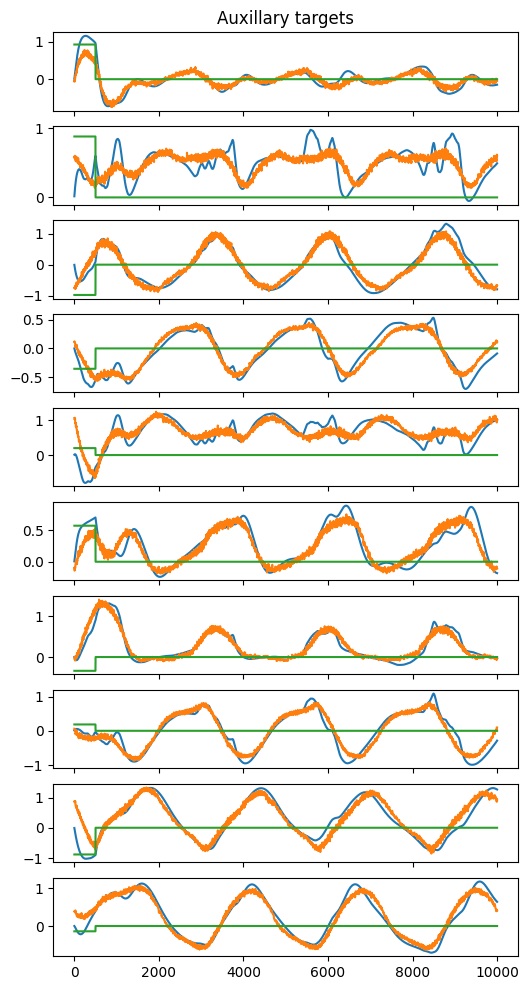

In [23]:
n_plot = 10

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(aux_targs[i])
    axs[i].plot(sdrive_t[i][(nloop - 1)*int(T/dt):nloop*int(T/dt)])
    axs[i].plot(fin[i])

axs[0].set_title("Auxillary targets")

Text(0.5, 1.0, 'Synaptic drive over training')

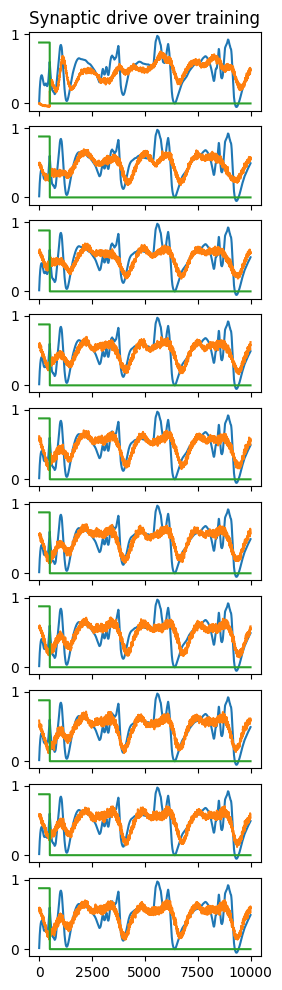

In [25]:
ind = 1

fig, axs = plt.subplots(nloop, 1, figsize = (3, 12), sharex = True)
for i in range(nloop):
    axs[i].plot(aux_targs[ind])
    axs[i].plot(sdrive_t[ind][i*int(T/dt):(i+1)*int(T/dt)])
    axs[i].plot(fin[ind])
axs[0].set_title("Synaptic drive over training")

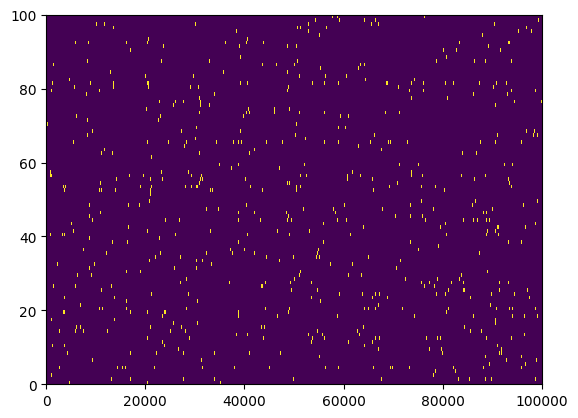

In [26]:
plt.pcolormesh(spk_rast_t)

(0.0, 10000.0)

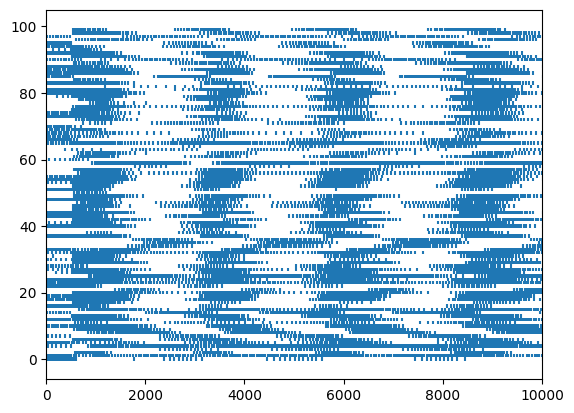

In [33]:
spk_inds, spk_t = np.nonzero(spk_rast_t)
spk_times = []
for idx in np.unique(spk_inds):
    spk_times.append(spk_t[spk_inds == idx])

plt.eventplot(spk_times);
plt.xlim(0, 10000)